<a href="https://colab.research.google.com/github/reeaarana/Malaria-Cell-Image-Classification-Using-InceptionV3-with-Attention-Mechanism/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os


In [ ]:
import kagglehub

path = kagglehub.dataset_download("arifmia/cell-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arifmia/cell-image-classification/versions/1


In [ ]:
parasitized_path = "/root/.cache/kagglehub/datasets/arifmia/cell-image-classification/versions/1/Cell_image_dataset/train/parasitized"
uninfected_path = "/root/.cache/kagglehub/datasets/arifmia/cell-image-classification/versions/1/Cell_image_dataset/train/uninfected"

In [ ]:
data = []

for file in os.listdir(parasitized_path):
  if file.endswith(".png") or file.endswith(".jpg"):
    data.append([os.path.join(parasitized_path, file), 'parasitized'])

for file in os.listdir(uninfected_path):
  if file.endswith(".png") or file.endswith(".jpg"):
    data.append([os.path.join(uninfected_path, file), 'uninfected'])

df = pd.DataFrame(data, columns=['file_path', 'label'])
df.head()
df.shape
df.columns
pd.Index(['file_path', 'label'], dtype='object')
sampled_df = df.groupby('label').sample(n=2000, random_state=42)
sampled_df['label'].unique()
np.array(['parasitized', 'uninfected'], dtype=object)
sampled_df['label'].value_counts()

,count
label,
parasitized,2000
uninfected,2000


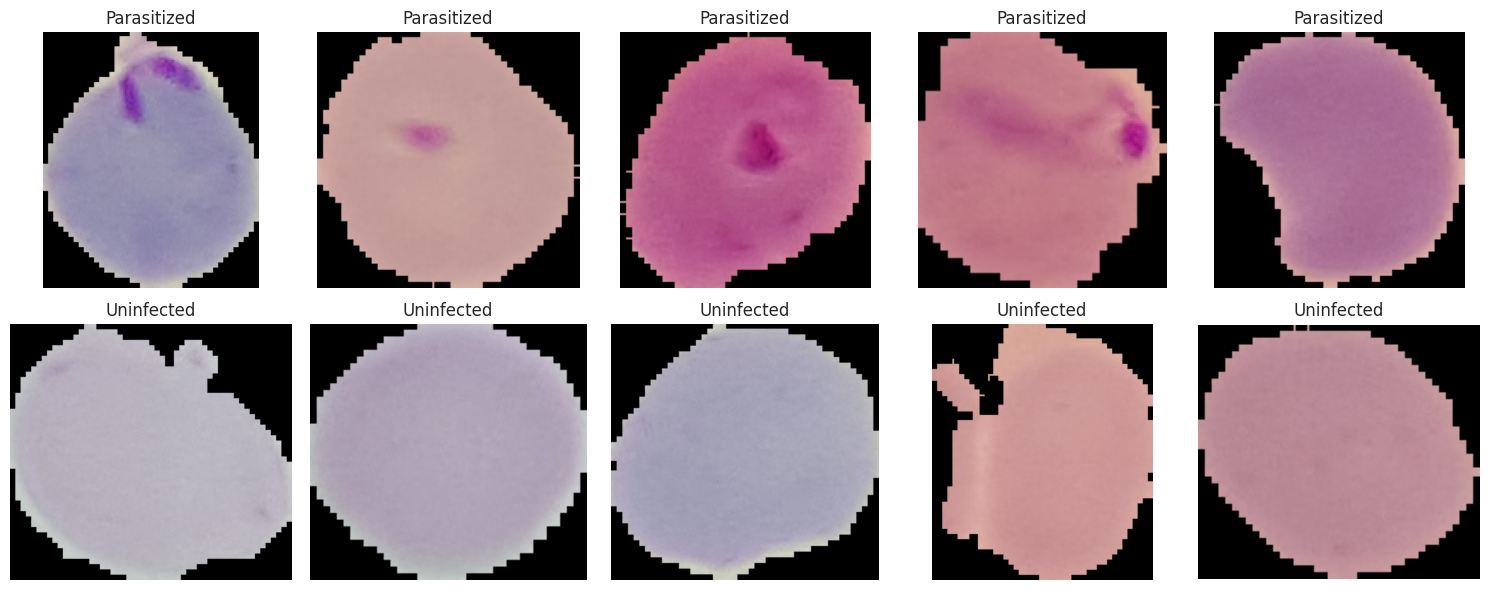

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):

  img_parasitized = Image.open(sampled_df[sampled_df['label'] ==
                                          'parasitized'].iloc[i]['file_path'])
  axes[0 ,i].imshow(img_parasitized, cmap='gray')
  axes[0, i].set_title("Parasitized")
  axes[0, i].axis('off')

  img_uninfected = Image.open(sampled_df[sampled_df['label'] == 'uninfected'].iloc[i]['file_path'])
  axes[1, i].imshow(img_uninfected, cmap='gray')
  axes[1, i].set_title("Uninfected")
  axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

train_df_new, temp_df_new = train_test_split(
    sampled_df,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=sampled_df['label']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['label']
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='file_path',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='file_path',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='file_path',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)





check
Found 3200 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
  print("Using GPU")
else:
  print("Using CPU")

Using GPU


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
restore_best_weights=True)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
def create_inception_model(input_shape):
  inputs = Input(shape=input_shape)
  base_model = InceptionV3(weights='imagenet', input_tensor=inputs,
                           include_top=False)

  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output

  height, width, channels = 5, 5, 2048
  x = Reshape((height * width, channels))(x)
  attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x,x)
  attention_output = Reshape((height, width, channels))(attention_output)

  x = GaussianNoise(0.25)(attention_output)
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = GaussianNoise(0.25)(x)
  x = Dropout(0.25)(x)

  outputs = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=50,
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.8670 - loss: 0.3380 - val_accuracy: 0.8600 - val_loss: 0.3547
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.9231 - loss: 0.2015 - val_accuracy: 0.8825 - val_loss: 0.3580
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.9471 - loss: 0.1518 - val_accuracy: 0.8150 - val_loss: 0.5963
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9490 - loss: 0.1367 - val_accuracy: 0.8900 - val_loss: 0.3561
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.9599 - loss: 0.1107 - val_accuracy: 0.9125 - val_loss: 0.3079
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.9680 - loss: 0.0902 - val_accuracy: 0.9125 - val_loss: 0.3761
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 139ms/step - accuracy: 0.9726 - loss: 0.0834 - val_accuracy: 0.9175 - val_loss: 0.3094
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.9684 - loss: 0

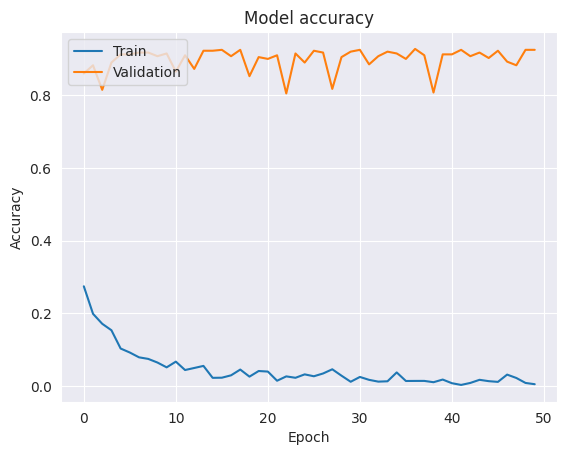

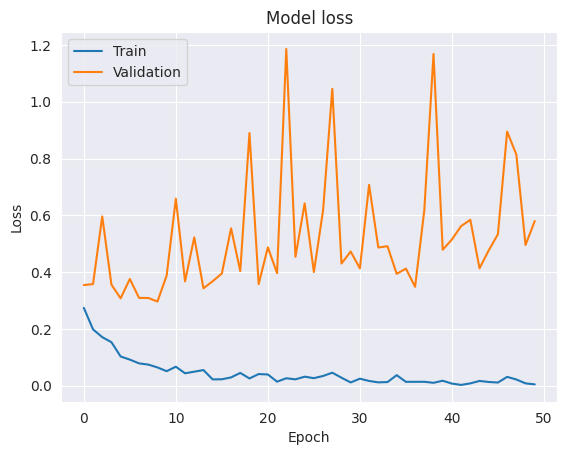

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()